# Messing around with the lightcurve code

In [1]:
import lightcurve as lc
import numpy as np
import rebound
import matplotlib.pyplot as plt

In [2]:
radii = np.array([2.0,1.2]) # in REarth
lc_test = lc.LightCurve(radii,'REarth','AU')
lc_test

In [3]:
x = np.array([True,False,False])
y = np.array([True,False,True])
x ^ y

array([False, False,  True])

# Rebound Transit Timing Variations Code

In [4]:
sim = rebound.Simulation()
sim.add(m=1)
sim.add(m=1e-5, a=1,e=0.1,omega=0.25)
sim.add(m=1e-5, a=1.757)
sim.move_to_com()

In [5]:
N=174
transittimes = np.zeros(N)
p = sim.particles
i = 0
while i<N:
    y_old = p[1].y - p[0].y  # (Thanks to David Martin for pointing out a bug in this line!)
    t_old = sim.t
    sim.integrate(sim.t+0.5) # check for transits every 0.5 time units. Note that 0.5 is shorter than one orbit
    t_new = sim.t
    if y_old*(p[1].y-p[0].y)<0. and p[1].x-p[0].x>0.:   # sign changed (y_old*y<0), planet in front of star (x>0)
        while t_new-t_old>1e-7:   # bisect until prec of 1e-5 reached
            if y_old*(p[1].y-p[0].y)<0.:
                t_new = sim.t
            else:
                t_old = sim.t
            sim.integrate( (t_new+t_old)/2.)
        transittimes[i] = sim.t
        i += 1
        sim.integrate(sim.t+0.05)       # integrate 0.05 to be past the transit

In [6]:
A = np.vstack([np.ones(N), range(N)]).T # linear least squares to fit 
c, m = np.linalg.lstsq(A, transittimes, rcond=-1)[0]

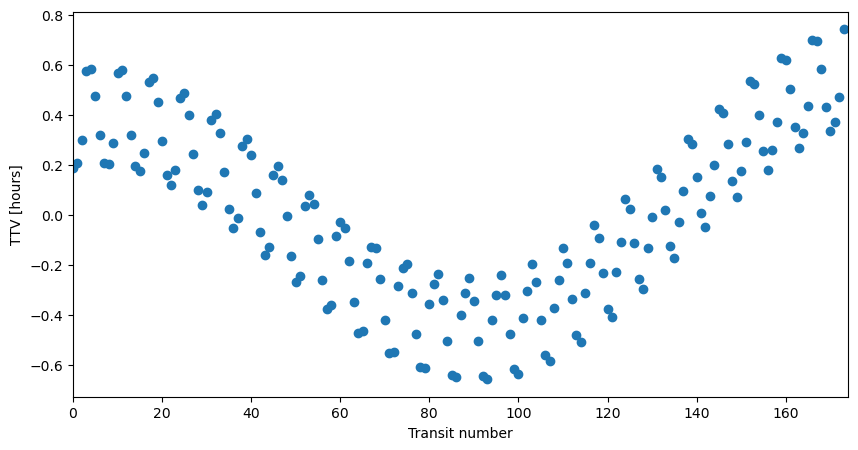

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.set_xlim([0,N])
ax.set_xlabel("Transit number")
ax.set_ylabel("TTV [hours]")
plt.scatter(range(N), (transittimes-m*np.array(range(N))-c)*(24.*365./2./np.pi));

# Testing ttv.py

## Step 1: Create and run a simulation

In [8]:
# Create a simulation
sim = rebound.Simulation()

# Set up units
sim.units = ('AU', 's', 'Msun')

In [9]:
'''Solar System, for testing'''
# Add the Sun
sim.add(m=1.0)

# Add the major planets with their approximate masses, semi-major axes, and eccentricities
# Masses are in solar masses, semi-major axes are in AU, and eccentricities are dimensionless

# Mercury
sim.add(m=1.65e-7, a=0.39, e=0.205,hash="mercury")
# sim.add(m=1.65e-7, a=0.39, e=0,hash="mercury")


# Venus
# sim.add(m=2.45e-6, a=0.72, e=0.007,hash="venus")

# Earth
# sim.add(m=3.00e-6, a=1.00, e=0.017,hash="earth")

# Mars
# sim.add(m=3.22e-7, a=1.52, e=0.093,hash="mars")

# Jupiter
# sim.add(m=9.54e-4, a=5.20, e=0.049,hash="jupiter")

# Saturn
# sim.add(m=2.86e-4, a=9.58, e=0.056,hash="saturn")

# Uranus
# sim.add(m=4.37e-5, a=19.22, e=0.046,hash="uranus")

# Neptune
# sim.add(m=5.15e-5, a=30.05, e=0.010,hash="neptune")

In [10]:
# Set the number of timesteps
year = 60*60*24*365.25 # seconds/year

t_total = 10*year
dt = 1e2 # seconds
num_timesteps = int(t_total/dt)
sim.dt=dt

# Create arrays to store positions
positions_x = np.zeros((num_timesteps, sim.N))
positions_y = np.zeros((num_timesteps, sim.N))

# Integrate the simulation for each timestep
for i in range(num_timesteps):
    # Record positions
    positions_x[i, :] = [p.x for p in sim.particles]
    positions_y[i, :] = [p.y for p in sim.particles]

    # Integrate for one timestep
    sim.integrate(sim.t+sim.dt)

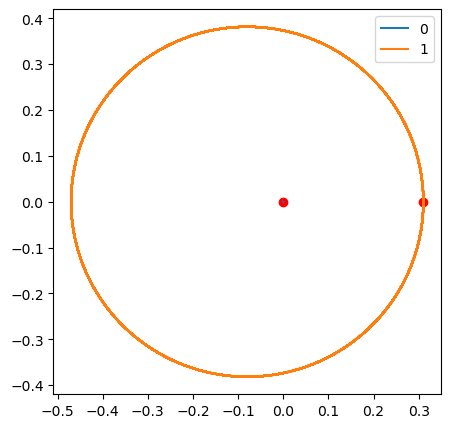

In [11]:
plt.figure(figsize=(5,5))
for i in range(2):
    plt.plot(positions_x[0,i],positions_y[0,i],c='r',ls='none',marker='o')
    plt.plot(positions_x[:,i],positions_y[:,i],label=i)
plt.legend()

## Step 2: Create lightcurves using lightcurves.py

In [12]:
from lightcurve import LightCurve
# radii = np.array([109,0.383,0.949,1,0.532,11.2,9.41,4.01,3.88])
radii = np.array([109,0.383])
# radii = np.array([109,0.383,0.949,1,0.532])
# names = ["sun","mercury","venus","earth","mars","jupiter","saturn","uranus","neptune"]
# names = ["sun","mercury","venus","earth","mars"]
names = ["sun","mercury"]
LC = LightCurve(radii_objects=radii, rad_unit="REarth",dist_unit="AU")
objects = LC.compute_lightcurve(positions_x.copy(),positions_y.copy(),names)

## Step 3: Compute TTVs using ttv.py

In [13]:
from ttv import TransitTimingVariations

In [14]:
TTVinit = TransitTimingVariations(objects,dt,"mercury")

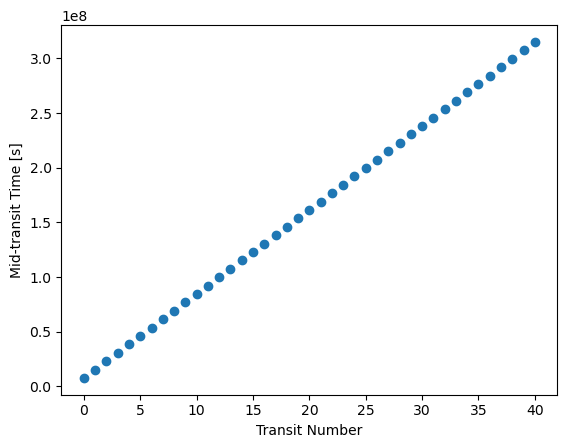

In [15]:
MTTs = TTVinit.compute_MTTs(plotfig=True)

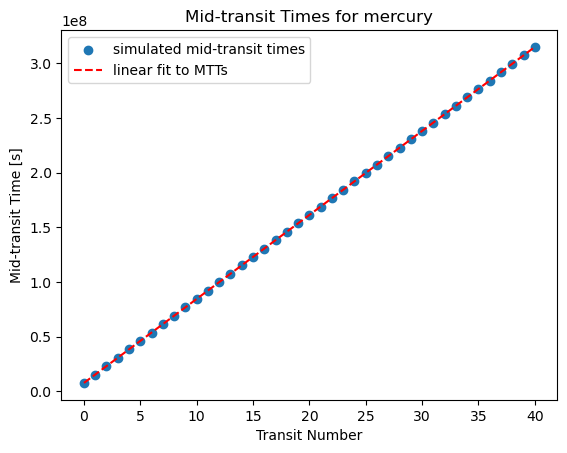

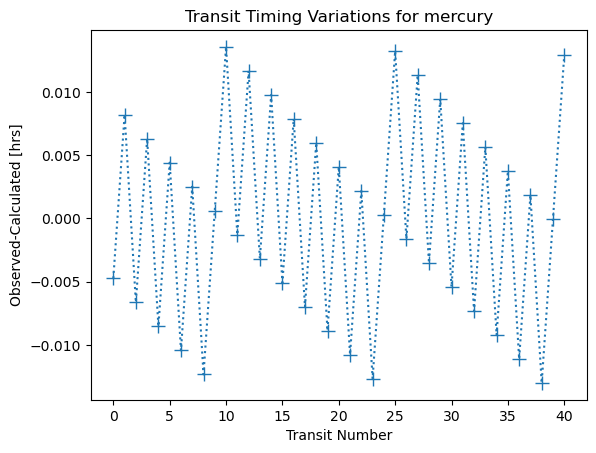

In [16]:
TTVs = TTVinit.compute_TTVs(plotfig=True,plot_time_units="hrs")

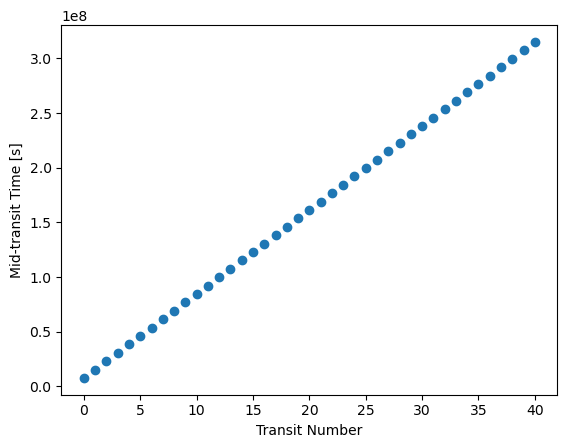

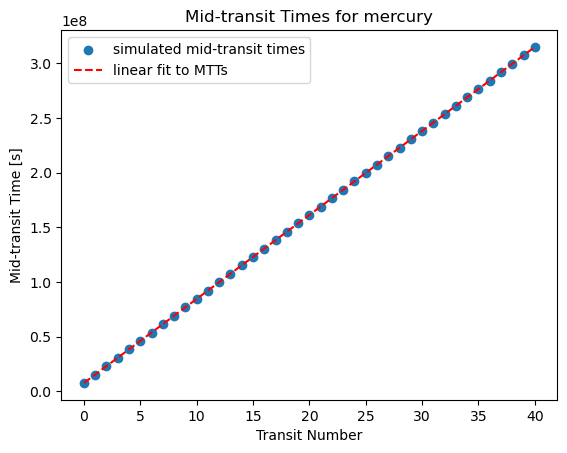

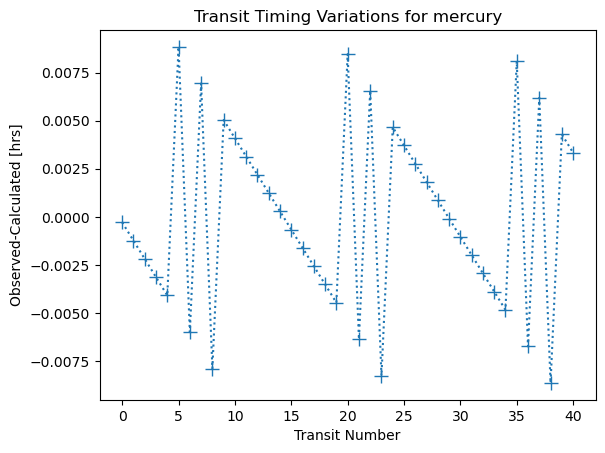

In [17]:
MTTs = TTVinit.compute_MTTs(plotfig=True,method='interpolate')
TTVs = TTVinit.compute_TTVs(plotfig=True,plot_time_units="hrs")